# 자료불러오기

영상을 불러오기위한 패키지인 rasterio를 설치해줍니다

In [1]:
%pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


그리고 분석에 필요한 패키지들을 로딩해줍니다

In [2]:
import numpy as np
import os.path
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

제가 불러올 파일의 이름을 지정해주고요

In [3]:
fname_img = "201804301CN0210003_subset_3000x3000.tif"

영상파일을 직접 업로도해도 되지만, 구글 드라이브에 올려놓고 gdown 명령어를 쓰면, 더 빨리 가져올수 있습니다. 
영상의 ID는 구글드라이브에서 영상을 우클릭하고 Get Link누르면 볼수 있습니다. 

In [7]:
! gdown --id 1TFBNFHIw12_uk4A1rq6EtkndcTnJS7ci

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1TFBNFHIw12_uk4A1rq6EtkndcTnJS7ci
To: /content/201804301CN0210003_subset_3000x3000.tif
100% 27.0M/27.0M [00:00<00:00, 55.9MB/s]


현재 이 Google Colab 세션에서 이 영상 파일을 잘 인식하고 있는지 확인해봅시다. 돌다리도 두들겨가면 나아가기 ㅎ

In [8]:
os.path.isfile(fname_img) 

True

네 True라고 뜨는것 보니까, 파일이 있는걸로 인식하고 있네요

이제 영상을 img라는 변수로 불러옵니다.

In [9]:
img = rasterio.open(fname_img)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


영상을 한번 띄워봅시다

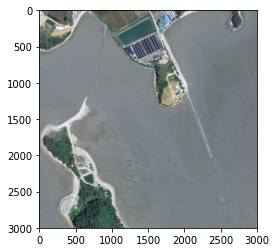

In [10]:
show(img)

img는 어떤 data type인지도 확인해보고요.

In [11]:
type(img)

rasterio.io.DatasetReader

그런데, 우리는 이 영상을 보기만 하는게 목적이 아니라, 영상 화소값을 요리조리 지지고볶고 해야하니까, 영상 화소값들을 array형태로 불러와야겠죠? 아래처럼 해줍니다

In [14]:
I = img.read()

잘 불러왔는지, 영상화소값의 dimension을 확인해봅니다.

In [15]:
I.shape


(3, 3000, 3000)

data type도 확인합니다.  

In [16]:
type(I)

numpy.ndarray

그런데 PCA를 돌리려면 data matrix 즉 X 행렬의 dimension이 n x p 가 되야하니까, 이 영상의 경우 9백만 x 3 이 되게 만들어줘야합니다.

그 첫번째 단계로, band가 맨 나중으로 가도록 축순서를 바꿔줍니다. (현재는 band가 맨 앞에 나와있죠? (3x3000x3000))

In [30]:
I = np.swapaxes(I, 0, 2)

band가 맨뒤로 갔는지 확인합니다

In [31]:
I.shape

(3000, 3000, 3)

그러고나서 이제 3000 x 3000 크기를 가진 영상을 한줄로 핍니다. 

In [32]:
X = I.reshape((3000*3000, 3))

이제 각 밴드 (r, g, b)의 화소들이 한줄로 쫙 펴졌네요

In [33]:
X.shape

(9000000, 3)

원래 I 에서의 화소들이 X의 어느 위치로 갔는지 확인해줍니다.

In [38]:
I[0,1, :]

array([214, 209, 202], dtype=uint8)

In [36]:
X[1, :]

array([214, 209, 202], dtype=uint8)

I에서 0행, 1열의 화소가,  X에서 두번째 화소가 되었군요 (index=1) (0부터 시작하니까 1이 두번째임)

In [39]:
I[1, 0, :]

array([189, 190, 190], dtype=uint8)

In [40]:
X[3000, :]

array([189, 190, 190], dtype=uint8)

I에서 1행 0열 화소는, 0행에 있는 3000개 화소를 다 소화하고 그 다음에 표시되니까 X에서는 3001번째 화소로 들어간것을 볼수 있습니다. (index로는 3000)

# PCA 돌리기

자 이제 PCA를 돌려봅시다. 원자료의 dimension이 3이었는데, 주성분(principal component)도 3개 구해봅시다. 3개 미만으로 해되됨. 

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

힘들게 얻은 우리 주성분들도 구경합니다.

In [46]:
print(pca.components_)

[[ 0.63898011  0.54191898  0.54591963]
 [-0.53231566 -0.20080064  0.82238625]
 [ 0.55528772 -0.81609002  0.16016435]]


첫번째와 두번째 주성분을 각각 x1, x2에 저장합니다. 
수업시간에 배운대로 각각의 주성분은 크기가 1이고, 서로 직교하는지 다시 확인해봅니다. (내적이 0이면 직교 증명완료!) 

In [90]:
x1 = pca.components_[:,0]
x2 = pca.components_[:,1]
np.dot(x1, x1)

1.0

In [91]:
np.dot(x1, x2)

5.551115123125783e-17

e-17이라는 것은 10의 마이너스 17승이라는 뜻입니다. 즉, 1/10^17 이라는것이니까 매우매우 작은 숫자죠. 0이라는 소리입니다. 

각 주성분이 가지는 variance의 크기도 확인합니다. 

In [47]:
print(pca.explained_variance_)

[2247.28417264   52.55019767   20.08254543]


In [ ]:
첫번째, 두번째, 세번째 주성분이 가지는 variance의 크기를 plot해봅니다. 
이 plot을 scree plot이라 한다고 배웠죠?

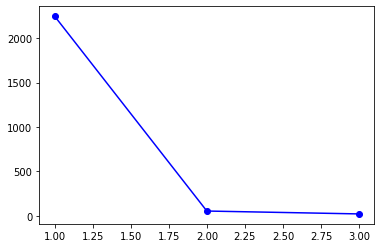

In [50]:
plt.plot(np.arange(3)+1, pca.explained_variance_, 'bo-')

이제 주성분을 얻었으니, 원자료 X에 적용해서, X를 변환시킵니다. 

In [51]:
X_pca = pca.transform(X)

In [ ]:
3개의 주성분을 이용했으니까, 원래 자료의 dimension과 같습니다. 

In [52]:
X_pca.shape

(9000000, 3)

변환된 값들이 어떤 범위를 가지는지 scatter plot을 그려봅니다. 

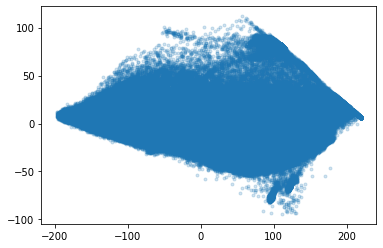

In [76]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', alpha=0.2)

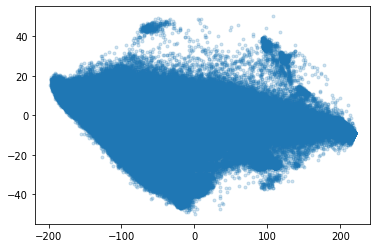

In [82]:
plt.scatter(X_pca[:, 0], X_pca[:, 2], marker='.', alpha=0.2)

data matrix형태에서 다시 영상 형태로 바꿔줍니다. 

In [58]:
I_pca = X_pca.reshape(3000, 3000, 3)

In [59]:
I_pca = np.swapaxes(I_pca, 0, 1)

첫번째부터 세번째까지 하나씩 차례차례 변환된 영상을 살펴봅니다. 각 영상에서의 높고 낮은 값들이 무엇을 의미하는지 한번 나름대로 해석해보세요. 

우선 첫번째 주성분에 해당하는 변환화소 영상입니다. 
해변가의 도로들 이 매우 밝은 값(빨강)으로 나타나고, 논, 밭 같은 식생이 있는곳은 낮은 값(파랑)으로 나타나내요. 이 첫번째 주성분영상은 인공물/자연물 구분 영상이라고 이름 붙여볼까요?

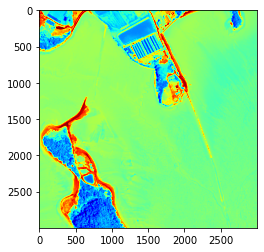

In [77]:
plt.imshow(I_pca[:,:,0], cmap='jet', vmin=-200, vmax=200)
plt.show()

두번째 주성분 영상입니다. 음.. 여기에서는 파랑지붕 건물이 매우 높은값으로 잡혔고, 나대지는 매우 낮은 값이네요. 

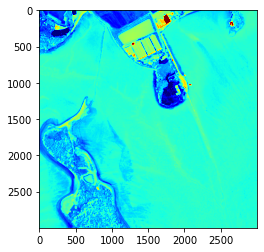

In [81]:
plt.imshow(I_pca[:,:,1], cmap='jet', vmin=-30, vmax=50)
plt.show()

마지막 주성분 영상도 나름대로 해석해보세요. 

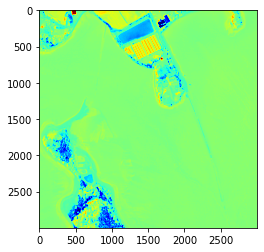

In [85]:
plt.imshow(I_pca[:,:,2], cmap='jet', vmin=-30, vmax=30)
plt.show()

마지막으로 각각의 주성분 영상을 각각 R, G, B 색깔을 할당해서 RGB영상으로만들면 아래처럼 보이겠네요. 

색깔만 봐도, 다른 유형의 객체가 다른 색깔로 구별되 보이는것 같네요. 

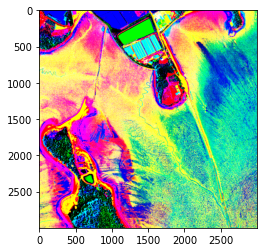

In [60]:
plt.imshow(I_pca)
plt.show()